# Discrete Non Linear Schödinger (NLS) :  WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-NLS">
             Initial value problem: NLS</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 

<li><a href="#Work-Precision-diagrams-(Float128)">
             Work-Precision diagrams (Float128)</a></li> 
             
<li><a href="#Save/Load-Data">
            Save/Load Data</a></li>              

</ul>  

## Loading packages

In [ ]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO

<a href="#top">Back to the top</a>

## Computer properties

In [11]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: NLS

In [12]:
include("../examples/NLS.jl")
include("../examples/InitialNLS.jl")

t0=0.0
t1=3.0


u064 =InitialNLS(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NLSODE!,u064,tspan64)

setprecision(BigFloat, 108);
u0128 =InitialNLS(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NLSODE!,u0128,tspan128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

(Array{Float64,1}, Tuple{Float64,Float64}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [ ]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/NLS_test_sol.jld2" sol

@load "./Data/NLS_test_sol.jld2" sol
test_sol = TestSolution(sol);
sol.destats

u0256=InitialNLS(BigFloat)
E0=NLSHam(u0256,[])
(Float32(sol.t[end]),Float32(NLSHam(sol.u[end],[])/E0-1))

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

### Computations

In [9]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

dts=collect(8.2e-3.*(1:length(reltols)));

In [10]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
]
solnames = ["Vern9","IRKGL16-adaptive","IRKGL16-fixed"]
wp1 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                       save_everystep=false,numruns=10,maxiters=10^9);

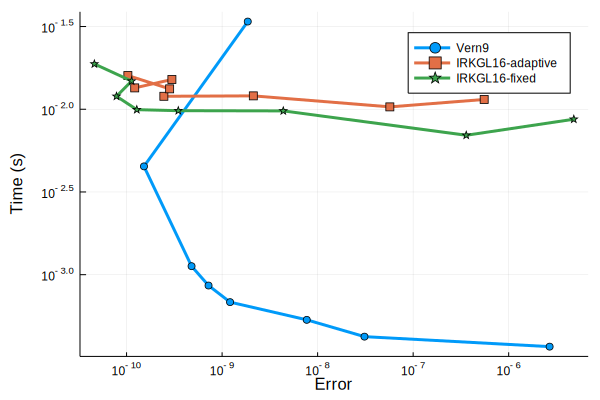

In [11]:
plot(wp1)

### WorkPrecision CPU-Time against Energy Error

In [15]:
pl=plot(title="Energy error", xlabel="t", ylabel="ΔE")
maxE1=[]
maxE2=[]
maxE9=[]
for k in 1:length(abstols)
    sol9=solve(prob64,Vern9(),abstol=abstols[k],reltol=reltols[k])
    ΔE9 = map(x->NLSHam(BigFloat.(x),[]), sol9.u)./E0.-1
    sol1= solve(prob64,IRKGL16(),abstol=abstols[k],reltol=reltols[k]);
    ΔE1 = map(x->NLSHam(BigFloat.(x),[]), sol1.u)./E0.-1
    sol2= solve(prob64,IRKGL16(),adaptive=false, dt=dts[k]);
    ΔE2 = map(x->NLSHam(BigFloat.(x),[]), sol2.u)./E0.-1
    pl=plot!(sol9.t,log10.(abs.(ΔE9)), label="", color="blue")
    pl=plot!(sol1.t,log10.(abs.(ΔE1)), label="", color="red")
    pl=plot!(sol2.t,log10.(abs.(ΔE2)), label="", color="green")
    push!(maxE1,maximum(log10.(abs.(ΔE1))))
    push!(maxE2,maximum(log10.(abs.(ΔE2))))
    push!(maxE9,maximum(log10.(abs.(ΔE9))))
end
plot(pl)

In [5]:
plot(xlabel="MaxE", ylabel="CPU")
plot!(maxE9,log10.(wp1[1].times), seriestype=:scatter,label="Vern9", color="blue")
plot!(maxE9,log10.(wp1[1].times), label="",color="blue")
plot!(maxE1,log10.(wp1[2].times),seriestype=:scatter, label="IRKGL16-A",color="red")
plot!(maxE1,log10.(wp1[2].times), label="",color="red")
plot!(maxE2,log10.(wp1[3].times), seriestype=:scatter, label="IRKGL16-F",color="green")
plot!(maxE2,log10.(wp1[3].times),  label="",color="green")

UndefVarError: UndefVarError: maxE9 not defined

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

### Computations

In [32]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);
dts=collect(3.1e-3.*(1:length(reltols)));

In [7]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64)
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64,:threading=>true)
]
solnames = ["Vern9","IRKGL16-adaptive","IRKGL16-adaptive/Mix","IRKGL16-fix","IRKGL16-fix/Mix","IRKGL16-fix/Mix/thread"]
wp2 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,
                       names=solnames,save_everystep=false,numruns=10,maxiters=10^9);

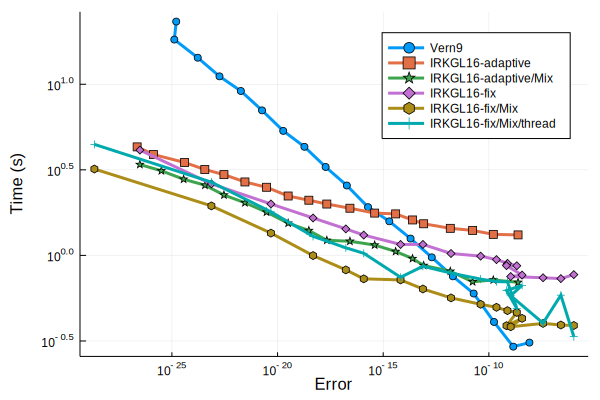

In [6]:
plot(wp2)

### Plot for JuliaCon2020

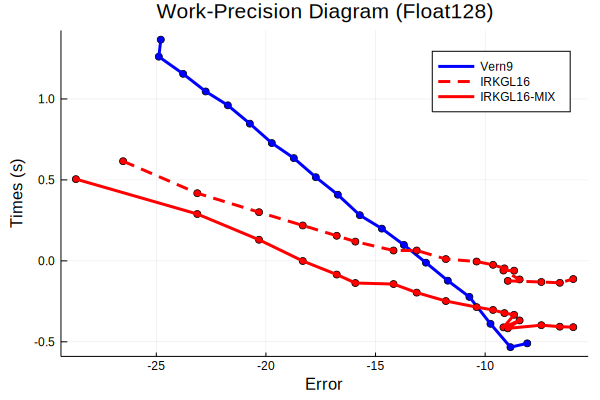

In [3]:
plot(title="Work-Precision Diagram (Float128)", xlabel="Error", ylabel="Times (s)")
k=1
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="", color="blue")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="Vern9", color="blue", lw=3)
# 
k=4
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="", color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="IRKGL16", color="red",lw=3,linestyle=:dash)
#
k=5
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="",color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="IRKGL16-MIX",color="red", lw=3)

### Save/Load Data

Load my own experiment's data executed

In [9]:
#@save "./Data/output/OutNLS_wp1.jld2" wp1
#@save "./Data/output/OutNLS_wp2.jld2" wp2

In [4]:
@load "./Data/output/OutNLS_wp1.jld2" wp1
@load "./Data/output/OutNLS_wp2.jld2" wp2

┌ Warning: read type ODEFunction{true,Main.#NLSODE!,UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /home/joseba/.julia/packages/JLD2/2W9VX/src/data.jl:1152
┌ Warning: read type ODEFunction{true,Main.#NLSODE!,UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /home/joseba/.julia/packages/JLD2/2W9VX/src/data.jl:1152


1-element Array{Symbol,1}:
 :wp2

<a href="#top">Back to the top</a>